In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from sklearn.model_selection import cross_val_score
from gecs100.gec import GEC
from gecs100.utils.gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process

gec = GEC()


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

enc = OneHotEncoder()
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
X, y = data2.values[:,:-1], data2.values[:,-1]
ind = np.random.uniform(0, 1, X.shape[0]) > 0.3
X = X[ind,:]
y = y[ind]

X_pos = X[y==1,:]
y_pos = y[y==1]

X_reweighted = np.concatenate([X] + [X_pos]*3, axis=0)
y_reweighted = np.concatenate([y] + [y_pos]*3)

/tmp/ipykernel_16845/3574338328.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_16845/3574338328.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [26]:
gec.fit(X_reweighted, y_reweighted, 100)

[LightGBM] [Warning] lambda_l1 is set=0.2840533673581254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2840533673581254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l1 is set=0.2840533673581254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2840533673581254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambd

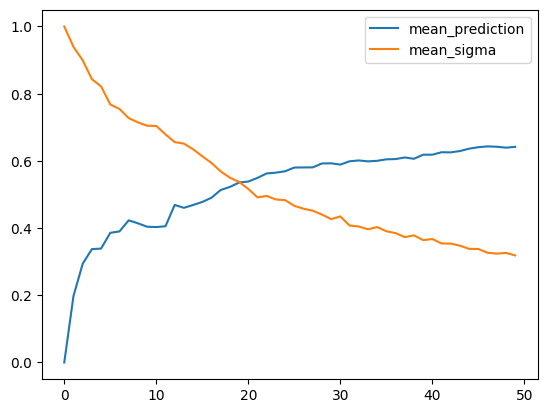

In [25]:

import matplotlib.pyplot as plt
x = np.arange(len(gec.gp_datas["gbdt"]["means"]))
gp_mean_prediction = [np.mean(x) for x in gec.gp_datas["gbdt"]["means"]]
gp_mean_sigma = [np.mean(x) for x in gec.gp_datas["gbdt"]["sigmas"]]

plt.plot(x, gp_mean_prediction, label="mean_prediction")
plt.plot(x, gp_mean_sigma, label="mean_sigma")
plt.legend(loc="upper right")

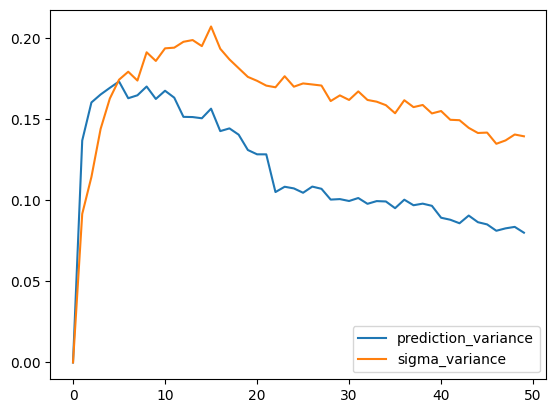

In [24]:

import matplotlib.pyplot as plt
x = np.arange(len(gec.gp_datas["gbdt"]["means"]))
gp_prediction_variance = [np.std(x) for x in gec.gp_datas["gbdt"]["means"]]
gp_sigma_variance = [np.std(x) for x in gec.gp_datas["gbdt"]["sigmas"]]

plt.plot(x, gp_prediction_variance, label="prediction_variance")
plt.plot(x, gp_sigma_variance, label="sigma_variance")
plt.legend(loc="lower right")


In [14]:
np.mean(gec.gp_datas["gbdt"]["sigmas"][x])

0.3186572978629564

In [7]:
np.array([gec.gp_datas["gbdt"][1][i:i+10].mean() for i in range(40)])

/tmp/ipykernel_15127/3746558834.py:1: RuntimeWarning: Mean of empty slice.
  np.array([gec.gp_datas["gbdt"][1][i:i+10].mean() for i in range(40)])
/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([0.68242862, 0.68220495, 0.68303048, 0.68432713, 0.6870815 ,
       0.67944974, 0.68153072, 0.68270481, 0.67786514, 0.68078757,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

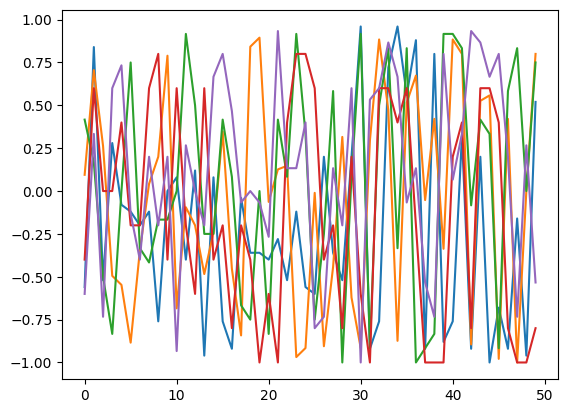

In [22]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
x = np.arange(gec.gp_datas["gbdt"][0].shape[0])
for i in range(gec.gp_datas["gbdt"][0].shape[1]):
    plt.plot(x, gec.gp_datas["gbdt"][0][:,i], label ='y1')


In [21]:
gec.gp_datas["gbdt"][0].shape[1]

5

In [ ]:
np.mean(gec.predict(X))

0.12701106083459024

In [9]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

{'boosting': 'gbdt', 'lambda_l1': 0.8539015263903917, 'num_leaves': 172, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'learning_rate': 0.10904009140848886}
[LightGBM] [Warning] lambda_l1 is set=0.8539015263903917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8539015263903917
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.8539015263903917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8539015263903917
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

0.6419084391667265

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
classifier = LGBMClassifier()
hyperparams = dict(gec.categorical_hyperparameters + gec.real_hyperparameters)
gs = RandomizedSearchCV(classifier, hyperparams, n_iter=1)
gs.fit(X_reweighted, y_reweighted)

[LightGBM] [Warning] lambda_l1 is set=0.2840533673581254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2840533673581254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] lambda_l1 is set=0.2840533673581254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2840533673581254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] lambda_l1

RandomizedSearchCV(estimator=LGBMClassifier(), n_iter=1,
                   param_distributions={'boosting': ['gbdt'],
                                        'feature_fraction': [0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5, 0.6,
                                                             0.7000000000000001,
                                                             0.8, 0.9, 1.0],
                                        'lambda_l1': array([0.        , 0.0053459 , 0.01094902, 0.01682171, 0.02297696,
       0.02942836, 0.03619015, 0.04327728, 0.05070539, 0.05849089,
       0.06665097, 0.07520366, 0.08416785, 0.0935633...
       0.06035172, 0.06793115, 0.07646246, 0.0860652 , 0.09687393,
       0.10904009, 0.12273418, 0.13814807, 0.15549776, 0.17502635,
       0.1970075 , 0.2217492 , 0.24959816, 0.2809446 , 0.31622777]),
                                        'min_data_in_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20, 22,
                                                             24, 26, 28, 30, 32,
                                                             34, 36, 38, 40, 42,
                                                             44, 46, 48],
                                        'num_leaves': [10, 11, 12, 13, 14, 15,
                                                       16, 17, 18, 19, 20, 21,
                                                       22, 23, 24, 25, 26, 27,
                                                       28, 29, 30, 31, 32, 33,
                                                       34, 35, 36, 37, 38, 39, ...]})

In [ ]:
X_eval, y_eval = X_reweighted, y_reweighted
#knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(gec, X_eval, y_eval, cv=5))

#knn_gs = LGBMClassifier(**gs.best_params_)
#score_gs = np.mean(cross_val_score(knn_gs, X_eval, y_eval, cv=5))
#score_gs= "None"
#knn_default = LGBMClassifier()
#score_default = np.mean(cross_val_score(knn_default, X_eval, y_eval, cv=5))
print(f"bayesian: {score_bayes}, random search: {score_gs}, default: {score_default}")


[LightGBM] [Warning] lambda_l1 is set=0.06665096884511756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06665096884511756
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] lambda_l1 is set=0.06665096884511756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06665096884511756
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignor

KeyboardInterrupt: 

In [ ]:
gs.best_params_

In [ ]:
print(np.mean(gec.predict(X)))
gec.best_params_

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=gec.kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(gec.gp_datas['gbdt'][0], gec.gp_datas['gbdt'][1])

In [ ]:
visualise_2D_gaussian_process(gaussian, (np.logspace(0.00, 1, 50) -1)/9, np.arange(10, 200, 1), np.arange(0.5, 1, 0.1))

In [ ]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

In [ ]:
knn_bayes = LGBMClassifier(**{'boosting': 'gbdt', 'lambda_l1': 0.46, 'num_leaves': 12})
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes